### Design and implementation of  automated and dynamic clinical pathways for low resource settings

###### Tracing Evidence from historical records
##### By
Geletaw Sahle, Demesewu Amenu, Girum Ketema, Frank Verbeke, Jan Cornelis, and Bart Jansen

## 1. Importing Library and Pacakges

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score
from sklearn.metrics import confusion_matrix

from sklearn.metrics import roc_curve, roc_auc_score


## 2. Importing the dataset

In [2]:
#Strategies I
#hcdata = pd.read_csv("HCTransformed11-Table 1.csv", encoding='utf-8')

#Strategies II

#hcdata = pd.read_csv("pregnancy-Table 1.csv", encoding='utf-8')

#Strategies III
#data after transformation 

#version 1.1 data
#hcdata = pd.read_csv("Pregnancy_AfterTRANS.csv", encoding='utf-8')

#Updated HC preprocessed data
hcdata = pd.read_csv("Preg2020-Table 1_Updated.csv", encoding='utf-8')

## 3. Clinical Pathways Data Description

In [3]:
hcdata.describe()

,Disease_Name,Category,Type,Status,DangerSign,abdominalPain,headache,SleepingSickness,Cough,Vomiting,...,Stress,HepatitisTest,RedEye,DarkUrine,Jaundice,Hypertension,AbdominalCramp,InfectionDeveloped,ART,CP
count,719,719,719,719,719,719,719,719,719,719,...,719,719,719,719,719,719,719,719,719,719
unique,1,32,28,50,4,3,3,4,4,3,...,3,4,3,3,3,3,3,3,3,2
top,Pregnancy,Normal Pregnancy,First ANC Visit,Normal Pregnancy,No,No,No,Notavailable,Notavailable,Notavailable,...,Notavailable,Notavailable,Notavailable,Notavailable,Notavailable,Notavailable,Notavailable,Notavailable,Notavailable,Treated
freq,719,79,138,63,331,303,308,361,361,392,...,676,682,688,685,684,669,632,657,608,532


In [4]:
 hcdata["CP"].describe() 

count         719
unique          2
top       Treated
freq          532
Name: CP, dtype: object

In [5]:
hcdata.shape

(719, 63)

In [6]:
# Group data by CP and summarize disease name 
hcdata.groupby(["CP"])[["Disease_Name"]].describe()

Disease_Name                       
               count unique        top freq
CP                                         
Refer            187      1  Pregnancy  187
Treated          532      1  Pregnancy  532

In [7]:
#hcdata.groupby(["Category"])[["CP"]].describe()

In [8]:
hcdata.head(2)

,Disease_Name,Category,Type,Status,DangerSign,abdominalPain,headache,SleepingSickness,Cough,Vomiting,...,Stress,HepatitisTest,RedEye,DarkUrine,Jaundice,Hypertension,AbdominalCramp,InfectionDeveloped,ART,CP
0,Pregnancy,Pregnant women that received ANC First visit b...,First ANC Visit,<16 weeks gestation,No,Yes,Yes,Yes,Yes,Yes,...,Notavailable,Notavailable,Notavailable,Notavailable,Notavailable,Notavailable,Notavailable,Notavailable,Notavailable,Treated
1,Pregnancy,Pregnant women that received ANC First visit b...,First ANC Visit,<16 weeks gestation,No,No,No,No,No,Notavailable,...,Notavailable,Notavailable,Notavailable,Notavailable,Notavailable,Notavailable,Notavailable,Notavailable,No,Treated


## 4. Check missing value percentage

In [9]:
# Function to calculate missing values by column
def missing_values_table(df):
   
    # Total missing values
    mis_val = df.isnull().sum()
    
    # Percentage of missing values
    mis_val_percent = 100 * df.isnull().sum() / len(df)
    
    # Make a table with the results
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
    
    # Rename the columns
    mis_val_table_ren_columns = mis_val_table.rename(
    columns = {0 : 'Missing Values', 1 : '% of Total Values'})
    
    # Sort the table by percentage of missing descending
    # .iloc[:, 1]!= 0: filter on missing missing values not equal to zero
    mis_val_table_ren_columns = mis_val_table_ren_columns[
        mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
    '% of Total Values', ascending=False).round(2)  # round(2), keep 2 digits
    
    # Print some summary information
    print("Your slelected dataframe has {} columns.".format(df.shape[1]) + '\n' + 
    "There are {} columns that have missing values.".format(mis_val_table_ren_columns.shape[0]))
    
    # Return the dataframe with missing information
    return mis_val_table_ren_columns

In [10]:
missing_values_table(hcdata)

Your slelected dataframe has 63 columns.
There are 3 columns that have missing values.


,Missing Values,% of Total Values
Pain,4,0.56
Complication,4,0.56
Fever,2,0.28


### 4.1. Imputing HealthCenter Dataset

#### 4.1.1. Define numerical Imputer

In [11]:
# define numerical imputer
#num_imputer = SimpleImputer(strategy='median')

In [12]:
# imputing on numerical data
#X[num_cols] = num_imputer.fit_transform(X[num_cols])

#### 4.1.2. Define Categorical Imputer

In [13]:
# DataframeMapper, CategoricalImputer
from sklearn_pandas import DataFrameMapper, CategoricalImputer
# categorical_imputer
class Categorical_Imputer:
    """
    Imputing categorical data using the most frequent value
    """
    
    # instance attribute
    def __init__(self, strategy):
        self.strategy = strategy
        
    # instance method
    def fit_transform(self, df:'dataframe')->'dataframe':
        """
        Fill in missing categorical values using most frequent value
        """
        
        # instantiate CategoricalImputer
        imputer = CategoricalImputer()
        
        # convert array to dataframe
        df_filled = df.apply(lambda x: imputer.fit_transform(x), axis=0)
        
        # return filled dataframe
        return df_filled

In [14]:
# define categorical imputer
Categorical_Imputer(hcdata)

In [15]:
# missing value table
missing_values_table(hcdata)

Your slelected dataframe has 63 columns.
There are 3 columns that have missing values.


,Missing Values,% of Total Values
Pain,4,0.56
Complication,4,0.56
Fever,2,0.28


## 5. Visualize the CP target Class 

In [16]:
def ClinicalPathways_ClassVIZ(data):
    pd.value_counts(data['CP']).plot.bar()
    plt.title('Clinical Pathways Class Histogram')
    plt.xlabel('CP')
    plt.ylabel('Frequency')
    data['CP'].value_counts()

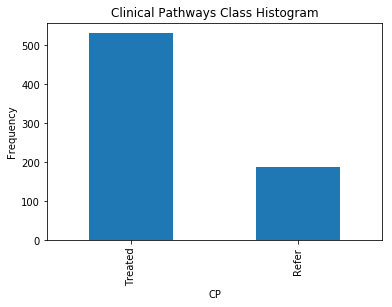

In [17]:
ClinicalPathways_ClassVIZ(hcdata)

### Challenges 
1. Data imbalance problem

In [18]:
# Counting the CP data class 
hcdata['CP'].value_counts()

Treated    532
Refer      187
Name: CP, dtype: int64

### Summarize the CP dataset 

In [19]:
# checking the dataset data types
#hcdata.info()

## 6. Converting into Categorical Values

In [20]:
def convert_into_categorical_values(CPdata):
    for col in CPdata:
        CPdata[col] = CPdata[col].astype('category')
    return CPdata

In [21]:
df = hcdata
df = convert_into_categorical_values(df)

In [22]:
# Checking the answer
#df.info()

In [23]:
df.head(2)

,Disease_Name,Category,Type,Status,DangerSign,abdominalPain,headache,SleepingSickness,Cough,Vomiting,...,Stress,HepatitisTest,RedEye,DarkUrine,Jaundice,Hypertension,AbdominalCramp,InfectionDeveloped,ART,CP
0,Pregnancy,Pregnant women that received ANC First visit b...,First ANC Visit,<16 weeks gestation,No,Yes,Yes,Yes,Yes,Yes,...,Notavailable,Notavailable,Notavailable,Notavailable,Notavailable,Notavailable,Notavailable,Notavailable,Notavailable,Treated
1,Pregnancy,Pregnant women that received ANC First visit b...,First ANC Visit,<16 weeks gestation,No,No,No,No,No,Notavailable,...,Notavailable,Notavailable,Notavailable,Notavailable,Notavailable,Notavailable,Notavailable,Notavailable,No,Treated


In [24]:
# df['Type'].values

In [25]:
df['Type'] = df['Type'].replace(np.nan, "NotKnown")
df.head(2)

,Disease_Name,Category,Type,Status,DangerSign,abdominalPain,headache,SleepingSickness,Cough,Vomiting,...,Stress,HepatitisTest,RedEye,DarkUrine,Jaundice,Hypertension,AbdominalCramp,InfectionDeveloped,ART,CP
0,Pregnancy,Pregnant women that received ANC First visit b...,First ANC Visit,<16 weeks gestation,No,Yes,Yes,Yes,Yes,Yes,...,Notavailable,Notavailable,Notavailable,Notavailable,Notavailable,Notavailable,Notavailable,Notavailable,Notavailable,Treated
1,Pregnancy,Pregnant women that received ANC First visit b...,First ANC Visit,<16 weeks gestation,No,No,No,No,No,Notavailable,...,Notavailable,Notavailable,Notavailable,Notavailable,Notavailable,Notavailable,Notavailable,Notavailable,No,Treated


## 7. Encoding the dataset 

In [26]:
# assign the copy of the original data
df = hcdata

#conver into categrorical variables
df = convert_into_categorical_values(df)

def LabelEncoding(CPdata):
    """Label Encoding: Simply converting each value in a column to a number. 
    Label encoding has the advantage that it is straightforward but it has the disadvantage that 
    the numeric values can be “misinterpreted” by the algorithms. 
    For example, the value of 0 is obviously less than the value of 4 but does 
    that really correspond to the data set in real life?
    """
    for col in CPdata:
        CPdata[col] = CPdata[col].cat.codes
    return CPdata

def oneHotEncoding(data):
    non_dummy_cols = ['CP'] 
    dummy_cols = list(set(data.columns) - set(non_dummy_cols))
    data = pd.get_dummies(data, columns=dummy_cols)
    return data

def frequencyEncoding(data):
    no_frq_cols = ['CP']
    frq_cols = list(set(data.columns) - set(no_frq_cols))
    for col in frq_cols:
        # create the dictionary
        count_CurrentColumn = data[col].value_counts().to_dict()
        # Map the column with dictionary
        data[col] = data[col].map(count_CurrentColumn)
    return data

In [27]:
#df=frequencyEncoding(df)

### Choose Encoding Techniques for Expermentation

In [ ]:
choice = int(input("1=Label Encoding, 2=ONE HOT Encoding, 3= Freqency Encoding "))
df = hcdata
df = convert_into_categorical_values(df)
if choice == 1:
    df = LabelEncoding(df)
    print("1- Label Encoding is Selected to encode the df")
elif choice == 2:
    df = oneHotEncoding(df)
    print("2- One Hot Encoding is Selected to encode the df")
else:
    df = frequencyEncoding(df)
    print("3- Frequency Encoding is selected")

#### Validate and Visualize the encoding 

In [ ]:
df.head(2)

In [ ]:
df.shape

## 8.  Split the target class

In [ ]:
def splitTargetClass(data):
    X = data.drop('CP', axis=1)
    y = data['CP']
    return X,y

In [ ]:
X,y = splitTargetClass(df)

## 9.  Baseline Classficaion model

In [ ]:
def dummyClassifier(X,y):
    """
     Before building a classification model, let’s build a Dummy Classifier to determine the ‘baseline’ performance. 
     This answers the question — ‘What would be the success rate of the model, if one were simply guessing?’ 
     The dummy classifier we are using will simply predict the majority class.
    """
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
    clf = DummyClassifier(strategy= 'most_frequent').fit(X_train,y_train)
    y_pred = clf.predict(X_test)
    
    #Distribution of y test
    print('y actual : \n' +  str(y_test.value_counts()))
    
    #Distribution of y predicted
    print('y predicted : \n' + str(pd.Series(y_pred).value_counts()))
    
    # Model Evaluation metrics ... from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score
    print('Accuracy Score : ' + str(accuracy_score(y_test,y_pred)))
    print('Precision Score : ' + str(precision_score(y_test,y_pred)))
    print('Recall Score : ' + str(recall_score(y_test,y_pred)))
    print('F1 Score : ' + str(f1_score(y_test,y_pred)))

    #Dummy Classifier Confusion matrix .... from sklearn.metrics import confusion_matrix
    print('Confusion Matrix : \n' + str(confusion_matrix(y_test,y_pred)))
    
    
    # prediction probabalities 
    r_probs = [0 for _ in range(len(y_test))]
    DummyClassifier_probs = clf.predict_proba(X_test)
    
    #probablities for the postive outcoe is kept
    DummyClassifier_probs = DummyClassifier_probs[:, 1]
    
    #calcualte AUROC
    DummyClassifier_auc = roc_auc_score(y_test, DummyClassifier_probs)
    print('Naive Bayes: DummyClassifier_auc = %.3f' % (DummyClassifier_auc))
    
    # Calculate ROC curev
    DummyClassifier_fpr, DummyClassifier_tpr, _ = roc_curve(y_test, DummyClassifier_probs)
    
    #Plot ROC Curve
    plt.plot(DummyClassifier_fpr, DummyClassifier_tpr, marker='.', label='DummyClassifier_ (DummyClassifier_auc = %0.3f)' % DummyClassifier_auc)
    # Title
    plt.title('ROC Plot')
    # Axis labels
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    # Show legend
    plt.legend() # 
    # Show plot
    DummyClassifierroc = plt.show()

In [ ]:
dummyClassifier(X,y)

In [ ]:
#class  dummy_classifier_class:
def dummy_classifier(X,y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
    clf = DummyClassifier(strategy= 'most_frequent').fit(X_train,y_train)
    y_pred = clf.predict(X_test)
    #Distribution of y test
    print('y actual : \n' +  str(y_test.value_counts()))
    
    #Distribution of y predicted
    print('y predicted : \n' + str(pd.Series(y_pred).value_counts()))

    # Model Evaluation metrics ... from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score
    print('Accuracy Score : ' + str(accuracy_score(y_test,y_pred)))
    print('Precision Score : ' + str(precision_score(y_test,y_pred)))
    print('Recall Score : ' + str(recall_score(y_test,y_pred)))
    print('F1 Score : ' + str(f1_score(y_test,y_pred)))
    
    #Dummy Classifier Confusion matrix .... from sklearn.metrics import confusion_matrix
    print('Confusion Matrix : \n' + str(confusion_matrix(y_test,y_pred)))

        
    # plot ROC Curve  
    def plot_ROC_Curve():
        # prediction probabalities 
        r_probs = [0 for _ in range(len(y_test))]
        DummyClassifier_probs = clf.predict_proba(X_test)

        #probablities for the postive outcoe is kept
        DummyClassifier_probs = DummyClassifier_probs[:, 1]

        #calcualte AUROC
        DummyClassifier_auc = roc_auc_score(y_test, DummyClassifier_probs)
        print('Naive Bayes: DummyClassifier_auc = %.3f' % (DummyClassifier_auc))

        # Calculate ROC curev
        DummyClassifier_fpr, DummyClassifier_tpr, _ = roc_curve(y_test, DummyClassifier_probs)

        #Plot ROC Curve
        plt.plot(DummyClassifier_fpr, DummyClassifier_tpr, marker='.', label='DummyClassifier_ (AUROC = %0.3f)' % DummyClassifier_auc)
        # Title
        plt.title('ROC Plot')
        # Axis labels
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        # Show legend
        plt.legend() # 
        # Show plot
        DummyClassifierroc = plt.show()
    plot_ROC_Curve()

In [ ]:
#dummy_classifier_class.plot_ROC_Curve()
dummy_classifier(X,y)

## 10 . Train Naive Bayes Clinical Pathways 

In [ ]:
def train_ClinicalPathways(parameters, target):
    # Split dataset into training set and test set
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25,random_state=42)
    nbmodel = GaussianNB()
    nbmodel.fit(X_train,y_train)
    y_pred = nbmodel.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)*100
    
    #draw ROC Curve
    fpr, tpr, thersholds = roc_curve(y_test, nbmodel.predict_proba(X_test)[:,1])


    #Distribution of y test
    print('y actual : \n' +  str(y_test.value_counts()))
    
    #Distribution of y predicted
    print('y predicted : \n' + str(pd.Series(y_pred).value_counts()))
    
    # Model Evaluation metrics ... from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score
    print('Accuracy Score : ' + str(accuracy_score(y_test,y_pred)))
    print('Precision Score : ' + str(precision_score(y_test,y_pred)))
    print('Recall Score : ' + str(recall_score(y_test,y_pred)))
    print('F1 Score : ' + str(f1_score(y_test,y_pred)))

    #Dummy Classifier Confusion matrix .... from sklearn.metrics import confusion_matrix
    print('Confusion Matrix : \n' + str(confusion_matrix(y_test,y_pred)))
    #return accuracy
    return y_pred

In [ ]:
train_ClinicalPathways(X,y)

#### Naive Bayes

In [ ]:
def CPNaiveBayes(X,y):
    #Train the size 
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25,random_state=42)
    nbmodel = GaussianNB()
    nbmodel.fit(X_train,y_train)
    
    """ # prediction probabalities 
    r_probs = [0 for _ in range(len(y_test))]
    nb_probs = nbmodel.predict_proba(X_test)
    
    #probablities for the postive outcoe is kept
    nb_probs = nb_probs[:, 1]
    
    #calcualte AUROC
    nb_auc = roc_auc_score(y_test, nb_probs)
    print('Naive Bayes: AUROC = %.3f' % (nb_auc))
    
    # Calculate ROC curev
    nb_fpr, nb_tpr, _ = roc_curve(y_test, nb_probs)
    
    #Plot ROC Curve
    plt.plot(nb_fpr, nb_tpr, marker='.', label='Naive Bayes (AUROC = %0.3f)' % nb_auc)
    # Title
    plt.title('ROC Plot')
    # Axis labels
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    # Show legend
    plt.legend() # 
    # Show plot
    nbroc = plt.show()
    # return nbroc
        # plot ROC Curve"""  
    def plot_ROC_Curve():
        # prediction probabalities 
        r_probs = [0 for _ in range(len(y_test))]
        nb_probs = nbmodel.predict_proba(X_test)

        #probablities for the postive outcoe is kept
        nb_probs = nb_probs[:, 1]

        #calcualte AUROC
        nb_auc = roc_auc_score(y_test, nb_probs)
        print('Naive Bayes: DummyClassifier_auc = %.3f' % (nb_auc))

        # Calculate ROC curev
        nb_fpr, nb_tpr, _ = roc_curve(y_test, nb_probs)

        #Plot ROC Curve
        plt.plot(nb_fpr,nb_tpr, marker='.', label='Naive Bayes_ (AUROC = %0.3f)' % nb_auc)
        # Title
        plt.title('ROC Plot')
        # Axis labels
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        # Show legend
        plt.legend() # 
        # Show plot
        #nbroc = plt.show()
    plot_ROC_Curve()

In [ ]:
CPNaiveBayes(X, y)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25,random_state=42)
nbmodel = GaussianNB()
nbmodel.fit(X_train,y_train)

#### Prediction probabilities 

In [ ]:
r_probs = [0 for _ in range(len(y_test))]
nb_probs = nbmodel.predict_proba(X_test)

Probabilities for the positive outcome is kept.

In [ ]:
nb_probs = nb_probs[:, 1]

#### Computing AUROC and ROC curve values¶

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score

#### Calculate AUROC

In [ ]:
nb_auc = roc_auc_score(y_test, nb_probs)

In [ ]:
print('Naive Bayes: AUROC = %.3f' % (nb_auc))

#### Calculate ROC curve

In [ ]:
nb_fpr, nb_tpr, _ = roc_curve(y_test, nb_probs)

#### Plot the ROC curve

In [ ]:
plt.plot(nb_fpr, nb_tpr, marker='.', label='Naive Bayes (AUROC = %0.3f)' % nb_auc)

# Title
plt.title('ROC Plot')
# Axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# Show legend
plt.legend() # 
# Show plot
plt.show()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25,random_state=42)
model = GaussianNB()
model.fit(X_train,y_train)

In [ ]:
y_pred = model.predict(X_test)
fpr,tpr, thersholds = roc_curve(y_test, model.predict_proba(X_test)[:,1])
roc_auc1 = roc_auc_score(y_test, model.predict(X_test))

In [ ]:
def plotROC():
    plt.figure()
    plt.plot(fpr, tpr, label='Naive Bayes Guassain(Sensitivity = %0.3f)' %roc_auc1)
    plt.plot([0,1],[0,1],'r--')
    plt.xlim([0.0,1.0])
    plt.ylim([0.0,1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver Operating Characteristic")
    plt.legend(loc="lower right")
    #plt.savefig('ROC')
    plt.show()

In [ ]:
plotROC()

Save the Model

In [ ]:
import pickle 

In [ ]:
# Save the trained model as a pickle string. 
saved_model = pickle.dumps(model) 
  
# Load the pickled model 
NB_from_pickle = pickle.loads(saved_model) 
  
# Use the loaded pickled model to make predictions 
NB_from_pickle.predict(X_test) 

#### Observation
1. Overfitting

In [ ]:
df.CP.value_counts()

Result: Dummy Classfication = 86%, Naive Bayes= 100% 

## 11. Handling the data imbalance

In [ ]:
# importing library package 
from sklearn.utils import resample

### Up-sample Minority Class
Up-sampling is the process of randomly duplicating observations from the minority class in order to reinforce its signal.

Approache: simply resample with replacement

In [ ]:
def UpSample_CP_MinorityClass(CPdata):
    # Separate majority and minority classes
    df_majority = CPdata[CPdata.CP==1]
    df_minority = CPdata[CPdata.CP==0]
 
    # Upsample minority class
    df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=576,    # to match majority class
                                 random_state=123) # reproducible results
 
    # Combine majority class with upsampled minority class
    df_upsampled = pd.concat([df_majority, df_minority_upsampled])
 
    # Display new class counts
    print(df_upsampled.CP.value_counts())
    return df_upsampled

In [ ]:
df_upsampled = UpSample_CP_MinorityClass(df)

#### Visualize after UpSampling the Minority Class

In [ ]:
ClinicalPathways_ClassVIZ(df_upsampled)

In [ ]:
X,y = splitTargetClass(df_upsampled)

In [ ]:
dummyClassifier(X,y)

In [ ]:
CPNaiveBayes(X, y)

### Down- Sample Majority Class

Down-sampling involves randomly removing observations from the majority class to prevent its signal from dominating the learning algorithm.



In [ ]:
def DownSample_CP_MajorityClass(CPdata):
    # Separate majority and minority classes
    df_majority = CPdata[CPdata.CP==1]
    df_minority = CPdata[CPdata.CP==0]
 
    # Downsample majority class
    df_majority_downsampled = resample(df_majority, 
                                 replace=False,    # sample without replacement
                                 n_samples=49,     # to match minority class
                                 random_state=123) # reproducible results
 
    # Combine minority class with downsampled majority class
    df_downsampled = pd.concat([df_majority_downsampled, df_minority])
 
    # Display new class counts
    print(df_downsampled.CP.value_counts())
    return df_downsampled



In [ ]:
CP_downsampled = DownSample_CP_MajorityClass(df)

In [ ]:
X,y = splitTargetClass(CP_downsampled)

In [ ]:
ClinicalPathways_ClassVIZ(CP_downsampled)

In [ ]:
X,y = splitTargetClass(CP_downsampled)

In [ ]:
dummyClassifier(X,y)

In [ ]:
train_ClinicalPathways(X,y)

In [ ]:
CPNaiveBayes(X, y)

### Handling Clinical Pathways Class Imbalance 

#### Importing Libraries and Packages 

In [ ]:
from imblearn.combine import SMOTETomek
# for under sampling 
from imblearn.under_sampling import NearMiss

## RandomOverSampler to handle imbalanced data
from imblearn.over_sampling import RandomOverSampler

#counting the values 
from collections import Counter

#### I. Under Sampling CP Class

In [ ]:
# Implementing Undersampling for Handling Imbalanced 
nm = NearMiss()
X_res,y_res=nm.fit_sample(X,y)

In [ ]:
X_res.shape,y_res.shape

In [ ]:
print('Original dataset shape {}'.format(Counter(y)))
print('Resampled dataset shape {}'.format(Counter(y_res)))

In [ ]:
dummy_classifier(X_res,y_res)

In [ ]:
CPNaiveBayes(X_res,y_res)

### II. Over Sampling CP Class: Using SMOTETomek

In [ ]:
# Implementing Oversampling for Handling Imbalanced 
smk = SMOTETomek(random_state=42)
X_res,y_res=smk.fit_sample(X,y)

In [ ]:
X_res.shape,y_res.shape

In [ ]:
print('Original dataset shape {}'.format(Counter(y)))
print('Resampled dataset shape {}'.format(Counter(y_res)))

In [ ]:
dummy_classifier(X_res,y_res)

In [ ]:
CPNaiveBayes(X_res,y_res)

### III. Over Sampling CP Class: Using Random Over Sampler

In [ ]:
os = RandomOverSampler(sampling_strategy=0.5)

In [ ]:
X_train_res, y_train_res = os.fit_sample(X, y)

In [ ]:
X_train_res.shape,y_train_res.shape

In [ ]:
print('Original dataset shape {}'.format(Counter(y)))
print('Resampled dataset shape {}'.format(Counter(y_train_res)))

In [ ]:
dummy_classifier(X_res,y_res)

In [ ]:
CPNaiveBayes(X_res,y_res)

### IV.  SMOTE CP Class (Hybrid Method) - under sampling method (Tomek) in with an over sampling method (SMOTE).

In [ ]:
# In this example I use SMOTETomek which is a method of imblearn. SMOTETomek is a hybrid method
# which uses an under sampling method (Tomek) in with an over sampling method (SMOTE).
os_us = SMOTETomek(sampling_strategy=0.5)

X_train_res1, y_train_res1 = os_us.fit_sample(X, y)

In [ ]:
X_train_res1.shape,y_train_res1.shape

In [ ]:
print('Original dataset shape {}'.format(Counter(y)))
print('Resampled dataset shape {}'.format(Counter(y_train_res1)))

In [ ]:
dummy_classifier(X_res,y_res)

In [ ]:
CPNaiveBayes(X_res,y_res)

#### Clinical Pathways Heatmaps and Correlation Matrix Plots in Python

In [ ]:
def CPHeatmap():
    # Create Correlation Matrix
    corr_matrix = df.corr()
    #corr_matrix

    #Set Up Mask To Hide Upper Triangle
    mask = np.zeros_like(corr_matrix, dtype=np.bool)
    mask[np.triu_indices_from(mask)]= True
    
    #Create Heatmap in Seaborn
    f, ax = plt.subplots(figsize=(30, 40))

    heatmap = sns.heatmap(corr_matrix,
                          mask = mask,
                          square = True,
                          linewidths = .5,
                          cmap = 'coolwarm',
                          cbar_kws = {'shrink': .4,
                                    'ticks' : [-1, -.5, 0, 0.5, 1]},
                          vmin = -1,
                          vmax = 1,
                          annot = True,
                          annot_kws = {"size": 12})

    #add the column names as labels
    ax.set_yticklabels(corr_matrix.columns, rotation = 0)
    ax.set_xticklabels(corr_matrix.columns)

    sns.set_style({'xtick.bottom': True}, {'ytick.left': True})

In [ ]:
# Display the heatmap 
#CPHeatmap()

In [ ]:
def beforeCPDATASample():
    # Sample figsize in inches
    fig, ax = plt.subplots(figsize=(20,30))         
    # Imbalanced DataFrame Correlation

    corr = df.corr()
    sns.heatmap(corr, cmap='YlGnBu', annot_kws={'size':30}, ax=ax)
    ax.set_title("Imbalanced Correlation Matrix before sampling", fontsize=14)
    VIZ = plt.show()
    return VIZ

In [ ]:
#beforeCPDATASample()

In [ ]:
def afterCPDATASample():
    # Sample figsize in inches
    fig, ax = plt.subplots(figsize=(20,30))         
    # Imbalanced DataFrame Correlation
    corr = CP_downsampled.corr()
    sns.heatmap(corr, cmap='YlGnBu', annot_kws={'size':30}, ax=ax)
    ax.set_title("Imbalanced Correlation Matrix after Sampling", fontsize=14)
    VIZ = plt.show()
    return VIZ

In [ ]:
#afterCPDATASample()